In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
passes_summary = pd.read_pickle("passes.pkl")
tracking_data = pd.read_pickle('tracking_data_full.pkl')
tracking = pd.read_pickle("tracking.pkl")
tracking_ball = pd.read_pickle('tracking_ball.pkl')

In [74]:
ballbesitz = tracking[tracking['POSSESSION_TRACKABLE_OBJECT'].notna()]

spieler_team_df = ballbesitz[['POSSESSION_TRACKABLE_OBJECT', 'POSSESSION_GROUP']].drop_duplicates()

spieler_team_map = spieler_team_df.groupby('POSSESSION_TRACKABLE_OBJECT')['POSSESSION_GROUP'].agg(lambda x: x.mode())
away_team_ids = spieler_team_map[spieler_team_map == "away team"].index.tolist()
home_team_ids = spieler_team_map[spieler_team_map == "home team"].index.tolist()

In [75]:
tracking_data['TEAM'] = tracking_data['TRACK_ID'].apply(lambda x: 'home team' if x in home_team_ids else ('away team' if x != 55 else None))

KOnvertiere Daten, dass Team home imeer on lnks nach rechts spielt.

In [5]:
mask = passes_summary['PERIOD'] == 2
passes_summary.loc[mask, ['start_X', 'end_X']] *= -1
passes_summary.loc[mask, ['start_Y', 'end_Y']] *= -1
mask = tracking_data['PERIOD'] == 2
tracking_data.loc[mask, ['X']] *= -1
tracking_data.loc[mask, ['Y']] *= -1
mask = tracking_ball['PERIOD'] == 2
tracking_ball.loc[mask, ['X']] *= -1
tracking_ball.loc[mask, ['Y']] *= -1

In [6]:
tracking_ball

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,...,ball_in_game,dX,dY,speed,angle,angle_change,angle_diff_2frames,ball_in_motion,motion_number,pass
2,105690,60,55,55,True,0.38,-1.03,1.0,NaN,<NA>,...,False,NaN,NaN,NaN,NaN,NaN,NaN,False,1,False
24,105690,61,55,55,True,0.23,-1.64,1.0,NaN,<NA>,...,True,-0.15,-0.61,0.628172,-103.815025,39.931137,-58.001322,False,1,False
47,105690,62,55,55,True,-1.12,-2.63,1.0,NaN,<NA>,...,True,-1.35,-0.99,1.674097,-143.746162,18.070185,14.572504,False,1,False
76,105690,63,55,55,False,-2.49,-3.08,1.0,NaN,<NA>,...,True,-1.37,-0.45,1.442012,-161.816347,-32.642689,33.659120,False,1,False
93,105690,64,55,55,False,-2.71,-3.35,1.0,NaN,<NA>,...,True,-0.22,-0.27,0.348281,-129.173658,-1.016431,6.512745,False,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108534,105690,57448,55,55,False,31.62,5.59,2.0,home team,<NA>,...,True,0.68,0.75,1.012373,47.802452,1.785473,1.260914,True,3918,False
1108559,105690,57449,55,55,False,30.79,4.73,2.0,home team,<NA>,...,True,0.83,0.86,1.195199,46.016978,-3.046388,19.383231,False,3919,False
1108580,105690,57450,55,55,False,29.94,3.75,2.0,home team,<NA>,...,True,0.85,0.98,1.297266,49.063366,-16.336843,-11.036135,False,3919,False
1108604,105690,57451,55,55,False,29.56,2.92,2.0,home team,<NA>,...,True,0.38,0.83,0.912853,65.400209,27.372979,NaN,False,3919,False


## Ballbesitz
Leider fehlen ein paar Labels in der Spalte POSSESSION_GROUP.  
Der Ball ist im Ballbesitz von Team home, falls das letzte vorkommene Label in POSSESSION_GROUP home team war.

In [7]:
tracking_data[['POSSESSION_GROUP', 'POSSESSION_TRACKABLE_OBJECT']].isna().sum()

POSSESSION_GROUP               189382
POSSESSION_TRACKABLE_OBJECT    840535
dtype: int64

In [8]:
tracking_data['POSSESSION_GROUP'] = (
    tracking_data['POSSESSION_GROUP'].fillna(
        tracking_data['POSSESSION_GROUP'].ffill()
    )
)

tracking_ball['POSSESSION_GROUP'] = (
    tracking_ball['POSSESSION_GROUP'].fillna(
        tracking_ball['POSSESSION_GROUP'].ffill()
    )
)

In [9]:
tracking_data.isna().sum()

MATCH_ID                            0
FRAME                               0
TRACK_ID                            0
TRACKABLE_OBJECT                    0
IS_VISIBLE                          0
X                                   0
Y                                   0
PERIOD                              0
POSSESSION_GROUP                  667
POSSESSION_TRACKABLE_OBJECT    840535
TIMESTAMP                           0
TIME_DELTA                          0
TEAM                            48202
dtype: int64

## Pressingsituation erkennen

Berechne Geschwindigkeit, Laufrichtung und Distanz zum Ball pro Spieler. Dafür ordne ich zunächst die tracking_data Reihenfolge um, damit für jeden Spieler alle vorhandenen Sequenzen hinterinander stehen.

In [10]:
# Sortieren, damit diff() korrekt arbeitet
tracking_data = tracking_data.sort_values(['TRACK_ID', 'FRAME'])

# Zeitdifferenz pro Spieler (in Sekunden)
tracking_data['dt'] = (
    tracking_data.groupby(['TRACK_ID'])['TIME_DELTA']
      .diff()
      .dt.total_seconds()
)

# Positionsdifferenzen pro Spieler
tracking_data['dx'] = tracking_data.groupby(['TRACK_ID'])['X'].diff()
tracking_data['dy'] = tracking_data.groupby(['TRACK_ID'])['Y'].diff()

tracking_data['SPEED'] = np.sqrt((tracking_data['dx']**2 + tracking_data['dy']**2))/tracking_data['dt']

In [11]:
tracking_data['move_angle']  = np.degrees(np.arctan2(tracking_data['dy'], tracking_data['dx']))

Bestimme den Winkel von Spieler zu Ball und teste so, ob sich der Spieler auf den Ball zubewegt.

In [12]:
ball_pos = (
    tracking_ball[['FRAME', 'X', 'Y']]
    .rename(columns={'X': 'ball_X', 'Y': 'ball_Y'})
)

tracking_data = tracking_data.merge(ball_pos, on='FRAME', how='left')

dx = tracking_data['ball_X'] - tracking_data['X']
dy = tracking_data['ball_Y'] - tracking_data['Y']

tracking_data['angle_to_ball'] = np.degrees(np.arctan2(dy, dx))
tracking_data['distance_to_ball'] = np.hypot(dx, dy)


In [13]:
def circdiff(a, b, period=360.0):
    return (a - b + period/2) % period - period/2

tracking_data['angle_diff_move_vs_ball'] = circdiff(tracking_data['angle_to_ball'], tracking_data['move_angle'])

In [14]:
tracking_data[tracking_data['FRAME'] == 2000]

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,...,dt,dx,dy,SPEED,move_angle,ball_X,ball_Y,angle_to_ball,distance_to_ball,angle_diff_move_vs_ball
1682,105690,2000,55,55,True,-16.27,-25.82,1.0,away team,28565,...,0.1,-0.73,0.26,7.749194,160.395912,-16.27,-25.82,0.000000,0.000000,-160.395912
56835,105690,2000,14926,14926,False,-31.63,-12.13,1.0,away team,28565,...,0.1,0.22,-0.28,3.560899,-51.842773,-16.27,-25.82,-41.709853,20.575366,10.132920
105037,105690,2000,16427,16427,False,1.17,7.91,1.0,away team,28565,...,0.1,0.27,-0.02,2.707397,-4.236395,-16.27,-25.82,-117.341095,37.971917,-113.104700
146288,105690,2000,16471,16471,True,-23.79,-6.06,1.0,away team,28565,...,0.1,0.19,-0.28,3.383785,-55.840305,-16.27,-25.82,-69.164837,21.142564,-13.324531
189498,105690,2000,16641,16641,True,3.76,9.23,1.0,away team,28565,...,0.1,0.31,-0.16,3.488553,-27.299572,-16.27,-25.82,-119.746642,40.369585,-92.447069
237700,105690,2000,16663,16663,True,-36.22,-1.17,1.0,away team,28565,...,0.1,-0.12,-0.08,1.442221,-146.309932,-16.27,-25.82,-51.015693,31.711591,95.294239
285902,105690,2000,24372,24372,True,-27.17,4.76,1.0,away team,28565,...,0.1,0.29,-0.17,3.361547,-30.379126,-16.27,-25.82,-70.381791,32.464541,-40.002665
334104,105690,2000,28435,28435,True,0.50,1.00,1.0,away team,28565,...,0.1,0.40,-0.12,4.176123,-16.699244,-16.27,-25.82,-122.016903,31.631397,-105.317659
382306,105690,2000,28437,28437,True,1.84,-20.25,1.0,away team,28565,...,0.1,-0.15,-0.11,1.860108,-143.746162,-16.27,-25.82,-162.903941,18.947216,-19.157779
436497,105690,2000,28540,28540,True,-6.04,-16.83,1.0,away team,28565,...,0.1,0.52,-0.14,5.385165,-15.068488,-16.27,-25.82,-138.691386,13.618847,-123.622898


## Ballbesitzphasen erkennen

Definiere Ballbesitzphasen, der Teams. Eine Ballbesitzphase endet immer dann, wenn sich der Ballbesitz der Mannschaft ändert.

In [15]:
tracking_ball['ballbesitzphase'] = (tracking_ball['POSSESSION_GROUP'] != tracking_ball['POSSESSION_GROUP'].shift()).cumsum()

In [16]:
def ballbesitz_info(group):
    start = group.iloc[0]
    end = group.iloc[-1]
    
    return pd.Series({
        'PERIOD': start['PERIOD'],
        'POSSESSION_GROUP': start['POSSESSION_GROUP'],
        'FRAME_START': start['FRAME'],
        'FRAME_END': end['FRAME'],
    })

# Nach motion_number gruppieren und pro Pass zusammenfassen
ballbesitz_summary = tracking_ball.groupby('ballbesitzphase').apply(ballbesitz_info).reset_index(drop=True)

In [17]:
ballbesitz_summary

,PERIOD,POSSESSION_GROUP,FRAME_START,FRAME_END
0,1.0,NaN,60.0,60.0
1,1.0,NaN,61.0,61.0
2,1.0,NaN,62.0,62.0
3,1.0,NaN,63.0,63.0
4,1.0,NaN,64.0,64.0
...,...,...,...,...
398,2.0,home team,56269.0,56520.0
399,2.0,away team,56521.0,57026.0
400,2.0,home team,57027.0,57051.0
401,2.0,away team,57052.0,57410.0


## Aufbausituationen eines Teams erkennen

In [18]:
tracking_data

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,...,dt,dx,dy,SPEED,move_angle,ball_X,ball_Y,angle_to_ball,distance_to_ball,angle_diff_move_vs_ball
0,105690,60,55,55,True,0.38,-1.03,1.0,NaN,<NA>,...,NaN,NaN,NaN,NaN,NaN,0.38,-1.03,0.000000,0.000000,NaN
1,105690,61,55,55,True,0.23,-1.64,1.0,NaN,<NA>,...,0.1,-0.15,-0.61,6.281720,-103.815025,0.23,-1.64,0.000000,0.000000,103.815025
2,105690,62,55,55,True,-1.12,-2.63,1.0,NaN,<NA>,...,0.1,-1.35,-0.99,16.740968,-143.746162,-1.12,-2.63,0.000000,0.000000,143.746162
3,105690,63,55,55,False,-2.49,-3.08,1.0,NaN,<NA>,...,0.1,-1.37,-0.45,14.420125,-161.816347,-2.49,-3.08,0.000000,0.000000,161.816347
4,105690,64,55,55,False,-2.71,-3.35,1.0,NaN,<NA>,...,0.1,-0.22,-0.27,3.482815,-129.173658,-2.71,-3.35,0.000000,0.000000,129.173658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108641,105690,57448,62046,62046,False,24.90,6.05,2.0,home team,<NA>,...,0.1,-0.08,0.02,0.824621,165.963757,31.62,5.59,-3.915924,6.735726,-169.879680
1108642,105690,57449,62046,62046,False,24.95,6.03,2.0,home team,<NA>,...,0.1,0.05,-0.02,0.538516,-21.801409,30.79,4.73,-12.549582,5.982942,9.251827
1108643,105690,57450,62046,62046,False,25.06,5.99,2.0,home team,<NA>,...,0.1,0.11,-0.04,1.170470,-19.983107,29.94,3.75,-24.655899,5.369544,-4.672792
1108644,105690,57451,62046,62046,False,25.22,5.92,2.0,home team,<NA>,...,0.1,0.16,-0.07,1.746425,-23.629378,29.56,2.92,-34.653943,5.275945,-11.024566


In [19]:
def is_chaos(row):
    frames = range(int(row['FRAME_START']), int(row['FRAME_END']) + 1)
    if len(frames) <= 50:
        return True
    
    counter_chaos = 0

    for frame in frames:
        frame_data = tracking_data[tracking_data['FRAME'] == frame]
        if (frame_data[frame_data['X'] > 0].shape[0] > 16) or (frame_data[frame_data['X'] < 0].shape[0] > 16):  # viele Spieler in einer Hälfte
            counter_chaos += 1

    return counter_chaos > 0.5 * len(frames)
        

ballbesitz_summary['chaos'] = ballbesitz_summary.apply(is_chaos, axis = 1)

In [20]:
ballbesitz_summary_geordnet = ballbesitz_summary[~ballbesitz_summary['chaos']]

In [21]:
ballbesitz_summary_geordnet

,PERIOD,POSSESSION_GROUP,FRAME_START,FRAME_END,chaos
29,1.0,away team,89.0,147.0,False
31,1.0,away team,203.0,263.0,False
51,1.0,away team,1977.0,2266.0,False
54,1.0,home team,2740.0,2858.0,False
68,1.0,home team,4161.0,4792.0,False
...,...,...,...,...,...
382,2.0,home team,53342.0,53552.0,False
389,2.0,away team,54666.0,54794.0,False
390,2.0,home team,54795.0,55066.0,False
391,2.0,away team,55067.0,55133.0,False


## Hohes Anlaufen bei langsamem Aufbau von hinten erkennen

Teste jetzt ob das Team in der Ballbesitzphase unter Druck gesetzt wird:
 - Ballbesitz in der eigenen Hälfte  
    und  
 - mind. 2 Spieler aus dem gegenerischen Team bewegen sich mit hoher Geschwindigkeit auf den Ball zu  
    oder  
 - Spieler des gegenerischen Teams sind nah in Richtung des Balls orientiert

In [22]:
def under_pressure_in_own_half(frame, possession_group):
    player_frame = tracking_data[tracking_data['FRAME'] == frame]

    #Teste ob Ballbesitz in der eigenen Hälfte ist
    if possession_group == 'home team':
        if player_frame[player_frame['TRACK_ID'] == 55]['X'].iloc[0] < 0:
            return False
    
    if possession_group == 'away team':
        if player_frame[player_frame['TRACK_ID'] == 55]['X'].iloc[0] > 0:
            return False
    

    gegner_ids = home_team_ids if possession_group == 'away team' else away_team_ids

    gegner_frame = player_frame[player_frame['TRACK_ID'].isin(gegner_ids)]

    ball_frame = player_frame[player_frame['TRACK_ID'] == 55]

    if ball_frame['SPEED'].iloc[0] < 0.2 or np.abs(ball_frame['Y'].iloc[0]) >= 33.5:
        return False

    gegner_in_ballnähe = gegner_frame[(gegner_frame['distance_to_ball'] <= 7) & (gegner_frame['angle_diff_move_vs_ball'].abs() <= 90)]
    

    gegner_moving_towards_ball = gegner_frame[(gegner_frame['distance_to_ball'] <= 15) & (gegner_frame['angle_diff_move_vs_ball'].abs() <= 45) & (gegner_frame['SPEED'] >= 2)]

    if len(gegner_in_ballnähe) >= 1 or len(gegner_moving_towards_ball) >= 2:
        return True
    else:
        return False

under_pressure_in_own_half(57414, 'home team')


True

In [23]:
available_frames = set(tracking_data['FRAME'].unique())

from itertools import groupby

def high_pressing(row, threshold=10):
    frames = np.arange(int(row['FRAME_START']), int(row['FRAME_END']) + 1)
    mask = np.isin(frames, list(available_frames))
    # False für Frames ohne Daten
    under = np.array([under_pressure_in_own_half(f, row['POSSESSION_GROUP']) if m else False
                      for f, m in zip(frames, mask)])

    runs = [sum(1 for _ in g) for val, g in groupby(under) if val]  # Längen aller True-Runs
    max_seq = max(runs) if runs else 0
    total_frames = int(under.sum())
    n_seq_ge_thr = sum(r >= threshold for r in runs)

    return pd.Series({
        'max_pressure_seq': max_seq,
        'total_pressure_frames': total_frames,
        'n_pressure_sequences_ge_10': n_seq_ge_thr,
        'ends_with_pressure': sum(under[-50:]) >= 20    # kommen in den letzten 20 Frames mindestens 15 Frames unter Druck vor
    })


ballbesitz_summary_geordnet[['max_pressure_seq', 'total_pressure_frames', 'n_pressure_sequences_ge_10', 'ends_with_pressure']] = ballbesitz_summary_geordnet.apply(high_pressing, axis=1, result_type='expand')


C:\Users\User\AppData\Local\Temp\ipykernel_858748\936288930.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ballbesitz_summary_geordnet[['max_pressure_seq', 'total_pressure_frames', 'n_pressure_sequences_ge_10', 'ends_with_pressure']] = ballbesitz_summary_geordnet.apply(high_pressing, axis=1, result_type='expand')
C:\Users\User\AppData\Local\Temp\ipykernel_858748\936288930.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ballbesitz_summary_geordnet[['max_pressure_seq', 'total_pressure_frames', 'n_p

In [24]:
ballbesitz_summary_geordnet[ballbesitz_summary_geordnet['ends_with_pressure']]

,PERIOD,POSSESSION_GROUP,FRAME_START,FRAME_END,chaos,max_pressure_seq,total_pressure_frames,n_pressure_sequences_ge_10,ends_with_pressure
29,1.0,away team,89.0,147.0,False,31,31,1,True
77,1.0,away team,6525.0,6878.0,False,27,59,2,True
120,1.0,home team,13154.0,13442.0,False,46,94,3,True
128,1.0,home team,14186.0,14253.0,False,21,21,1,True
134,1.0,home team,14641.0,14841.0,False,16,22,1,True
147,1.0,away team,16399.0,16632.0,False,29,52,1,True
164,1.0,home team,18716.0,18840.0,False,68,119,3,True
171,1.0,away team,20391.0,20656.0,False,41,89,3,True
184,1.0,home team,23290.0,23543.0,False,11,24,1,True
185,1.0,away team,23544.0,23740.0,False,51,133,5,True


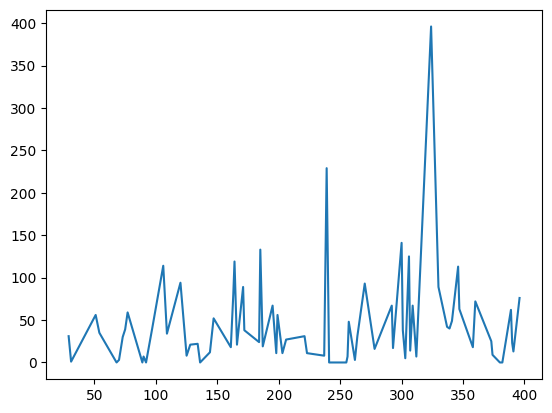

In [25]:
plt.plot(ballbesitz_summary_geordnet['total_pressure_frames'])

In [26]:
def average_x_ball(row):
    frames = np.arange(int(row['FRAME_START']), int(row['FRAME_END']) + 1)
    valid_frames = [f for f in frames if f in available_frames]
    ball_positions = tracking_ball[tracking_ball['FRAME'].isin(valid_frames)]
    
    if ball_positions.empty:
        return np.nan
    return ball_positions['X'].mean()

ballbesitz_summary_geordnet['average_x_ball'] = ballbesitz_summary_geordnet.apply(average_x_ball, axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_858748\609998339.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ballbesitz_summary_geordnet['average_x_ball'] = ballbesitz_summary_geordnet.apply(average_x_ball, axis=1)


In [27]:
ballbesitz_summary_geordnet.loc[ballbesitz_summary_geordnet['average_x_ball'] < -20]

,PERIOD,POSSESSION_GROUP,FRAME_START,FRAME_END,chaos,max_pressure_seq,total_pressure_frames,n_pressure_sequences_ge_10,ends_with_pressure,average_x_ball
68,1.0,home team,4161.0,4792.0,False,0,0,0,False,-38.864444
136,1.0,home team,15083.0,15521.0,False,0,0,0,False,-47.359010
161,1.0,away team,17429.0,17690.0,False,12,18,1,False,-41.593535
195,1.0,away team,25915.0,26084.0,False,43,67,2,False,-20.761471
256,2.0,home team,34743.0,34862.0,False,7,7,0,False,-22.467167
278,2.0,home team,37443.0,38180.0,False,8,16,0,False,-33.405000
380,2.0,home team,53244.0,53306.0,False,0,0,0,False,-31.192222
382,2.0,home team,53342.0,53552.0,False,0,0,0,False,-45.424928


In [28]:
import matplotlib.patches as patches

def plot_ballbesitz_phase(ballbesitz_df):
    def plot_spieler(tracking_df, frame, team0_ids=away_team_ids, team1_ids=home_team_ids, ball_id=55, ax=None):
        df = tracking_df[tracking_df['FRAME'] == frame]

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 7))
        
        ax.set_facecolor('green')
        ax.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white")

        ax.set_xlim(-55, 55)
        ax.set_ylim(-35, 35)
        ax.set_aspect('equal')


        for _, row in df.iterrows():
            if row['TRACK_ID'] == ball_id:
                ax.plot(row['X'], row['Y'], 'o', color='orange', markersize=10, label='Ball')
            elif team0_ids and row['TRACK_ID'] in team0_ids:
                ax.plot(row['X'], row['Y'], 'o', color='blue', label='Auswärts')
            elif team1_ids and row['TRACK_ID'] in team1_ids:
                ax.plot(row['X'], row['Y'], 'o', color='red', label='Heim')
            else:
                ax.plot(row['X'], row['Y'], 'o', color='gray')

        ball_pos = df[df['TRACK_ID'] == 55]
        ball_x = ball_pos['X'].iloc[0]
        ball_y = ball_pos['Y'].iloc[0]
        gegner_ids = home_team_ids if df['POSSESSION_GROUP'].iloc[0] == 'away team' else away_team_ids


        if under_pressure_in_own_half(frame, ballbesitz_df['POSSESSION_GROUP']):
            alpha = 0.5
            near_player = df[(((df['distance_to_ball'] <= 15) & (df['angle_diff_move_vs_ball'].abs() <= 90) & (df['SPEED'] >= 2)) | ((df['distance_to_ball'] <= 7) & (df['angle_diff_move_vs_ball'].abs() <= 180))) & (df['TRACK_ID'].isin(gegner_ids))]
            ax.plot(near_player['X'], near_player['Y'], 'o', color='orange', markersize=3)
            for _, row in near_player.iterrows():
                ax.plot([row['X'], ball_x], [row['Y'], ball_y], color='orange', linestyle='--', linewidth=1)

        else:
            alpha = 0.2

        circle = patches.Circle((ball_x, ball_y), radius=7,
                                facecolor='orange',    
                                edgecolor='orange',   
                                hatch='//',          
                                alpha=alpha,
                                linewidth=1.5)

        ax.add_patch(circle)

        circle = patches.Circle((ball_x, ball_y), radius=15,
                                facecolor='purple',    
                                edgecolor='purple',   
                                hatch='//',          
                                alpha=alpha,
                                linewidth=1.5)

        ax.add_patch(circle)

        ax.set_title(f"Frame {frame}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")


    
    tracking_frames = set(tracking_data['FRAME'].unique())
    frames = [f for f in range(int(ballbesitz_df['FRAME_START']), int(ballbesitz_df['FRAME_END']) + 80) if f in tracking_frames]

    if len(frames) == 0:
        print("Keine gültigen Frames für diese Ballbesitzphase.")
        return



    from matplotlib.animation import FuncAnimation
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    fig.suptitle("Hohes Pressing", fontsize=16)


    # Beispielanimation
    def update(frame):
        ax.clear()
        plot_spieler(tracking_data, frame, ax = ax)
        return ax,

    ani = FuncAnimation(fig, update, frames=frames, interval=200)

    plt.show()
    ani.save("ballbesitzphase.gif", writer='pillow')

# plot_ballbesitz_phase(ballbesitz_summary_geordnet.loc[270]) 
# 120 für Pressing, das klappt 13350 -> 


In [29]:
ballbesitz_summary_geordnet['pressing'] = ballbesitz_summary_geordnet.apply(lambda row: True if (row['max_pressure_seq'] >= 40) | (row['n_pressure_sequences_ge_10'] >= 3) else False, axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_858748\3701540071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ballbesitz_summary_geordnet['pressing'] = ballbesitz_summary_geordnet.apply(lambda row: True if (row['max_pressure_seq'] >= 40) | (row['n_pressure_sequences_ge_10'] >= 3) else False, axis=1)


In [30]:
pressing_situations = ballbesitz_summary_geordnet[ballbesitz_summary_geordnet['pressing']]

In [31]:
pressing_situations['PRESSING_TEAM'] = pressing_situations['POSSESSION_GROUP'].apply(
    lambda x: 'away team' if x == 'home team' else 'home team'
)

C:\Users\User\AppData\Local\Temp\ipykernel_858748\3708425629.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pressing_situations['PRESSING_TEAM'] = pressing_situations['POSSESSION_GROUP'].apply(


In [32]:
pressing_situations

,PERIOD,POSSESSION_GROUP,FRAME_START,FRAME_END,chaos,max_pressure_seq,total_pressure_frames,n_pressure_sequences_ge_10,ends_with_pressure,average_x_ball,pressing,PRESSING_TEAM
106,1.0,home team,10400.0,10717.0,False,41,114,3,False,8.033113,True,away team
120,1.0,home team,13154.0,13442.0,False,46,94,3,True,22.605779,True,away team
163,1.0,away team,17830.0,18715.0,False,19,80,5,False,-11.580644,True,home team
164,1.0,home team,18716.0,18840.0,False,68,119,3,True,6.947600,True,away team
171,1.0,away team,20391.0,20656.0,False,41,89,3,True,-18.037556,True,home team
185,1.0,away team,23544.0,23740.0,False,51,133,5,True,-4.320051,True,home team
195,1.0,away team,25915.0,26084.0,False,43,67,2,False,-20.761471,True,home team
239,2.0,away team,31720.0,32778.0,False,93,229,6,False,8.962424,True,home team
270,2.0,home team,36189.0,36612.0,False,30,93,3,True,26.419818,True,away team
292,2.0,home team,40678.0,40868.0,False,24,67,3,False,1.649424,True,away team


In [33]:
pressing_summary = pressing_situations.groupby('PRESSING_TEAM').agg(
    total_presses=('POSSESSION_GROUP', 'count'),
    successful_presses=('ends_with_pressure', 'sum')  # falls es diese Spalte gibt
).reset_index()

pressing_summary['success_rate'] = pressing_summary['successful_presses'] / pressing_summary['total_presses']


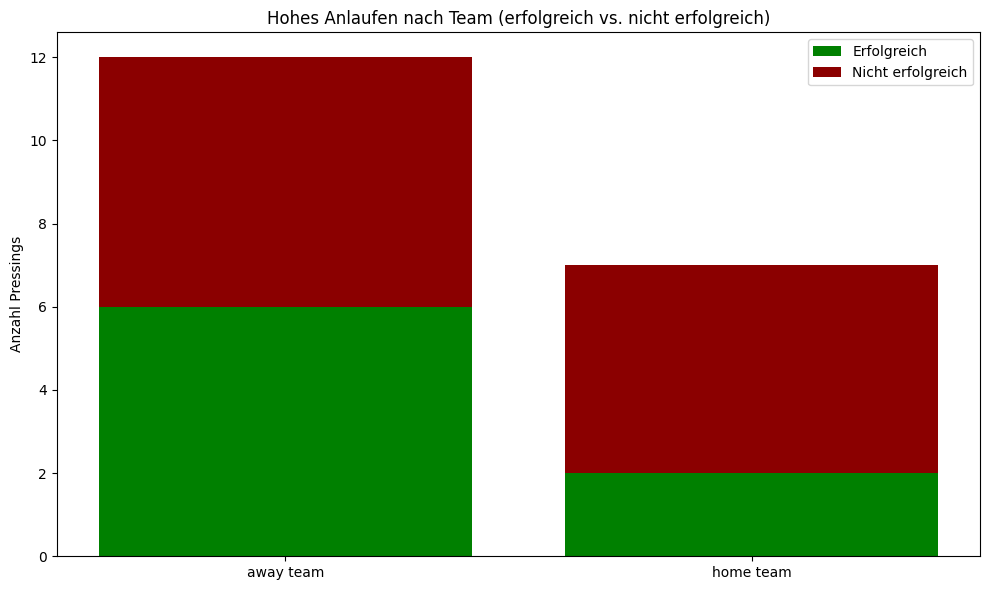

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
team_names = pressing_summary['PRESSING_TEAM']

success = pressing_summary['successful_presses']
fail = pressing_summary['total_presses'] - success

ax.bar(team_names, success, label='Erfolgreich', color='green')
ax.bar(team_names, fail, bottom=success, label='Nicht erfolgreich', color='darkred')

ax.set_ylabel('Anzahl Pressings')
ax.set_title('Hohes Anlaufen nach Team (erfolgreich vs. nicht erfolgreich)')
ax.legend()
plt.tight_layout()
plt.show()


In [35]:
ballbesitz_summary_geordnet

,PERIOD,POSSESSION_GROUP,FRAME_START,FRAME_END,chaos,max_pressure_seq,total_pressure_frames,n_pressure_sequences_ge_10,ends_with_pressure,average_x_ball,pressing
29,1.0,away team,89.0,147.0,False,31,31,1,True,-5.447119,False
31,1.0,away team,203.0,263.0,False,1,1,0,False,-1.167213,False
51,1.0,away team,1977.0,2266.0,False,28,56,2,False,-19.029345,False
54,1.0,home team,2740.0,2858.0,False,21,35,1,False,7.696050,False
68,1.0,home team,4161.0,4792.0,False,0,0,0,False,-38.864444,False
...,...,...,...,...,...,...,...,...,...,...,...
382,2.0,home team,53342.0,53552.0,False,0,0,0,False,-45.424928,False
389,2.0,away team,54666.0,54794.0,False,39,62,2,False,2.097984,False
390,2.0,home team,54795.0,55066.0,False,11,23,1,False,23.248346,False
391,2.0,away team,55067.0,55133.0,False,13,13,1,False,-5.858507,False


In [148]:
from sklearn.cluster import KMeans

def verteidigungskette(row):

    frames = range(int(row['FRAME_START']), int(row['FRAME_END']))

    ball_positions = tracking_data[
        (tracking_data['FRAME'].isin(frames)) &
        (tracking_data['TRACK_ID'] == 55)
    ]

    if ball_positions['Y'].abs().mean() > 25:
        return np.nan  # Ball zu weit außen --> Spielphase ignorieren

    defending_team = tracking_data[
        (tracking_data['FRAME'].isin(frames)) &
        (tracking_data['TEAM'] != row['POSSESSION_GROUP']) &
        (~tracking_data['TRACK_ID'].isin([29938, 16663, 55]))
    ]

    if defending_team['X'].max() - defending_team['X'].min() < 20:
        return np.nan  # Verteidigungskette zu eng 

    positions_defending = defending_team[['FRAME', 'TRACK_ID', 'X', 'Y']]  
    avg_positions = positions_defending.groupby('TRACK_ID')[['X', 'Y']].mean().reset_index()    #Wähle Durchschnitt der X-Koordinaten
    X = avg_positions[['X']]  

    kmeans = KMeans(n_clusters=3, random_state=41)
    avg_positions['cluster'] = kmeans.fit_predict(X)


    cluster_x_means = avg_positions.groupby('cluster')['X'].mean()
    abwehr_cluster = cluster_x_means.idxmin()  # Cluster mit tiefstem X-Wert

    abwehr_kette_groesse = avg_positions[avg_positions['cluster'] == abwehr_cluster].shape[0]
    
    if abwehr_kette_groesse < 3:
        return np.nan  
    
    return abwehr_kette_groesse

ballbesitz_summary_geordnet['verteidigungskette'] = ballbesitz_summary_geordnet.apply(verteidigungskette, axis=1)

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmea

In [111]:
ballbesitz_summary_geordnet['defending_team'] = ballbesitz_summary_geordnet['POSSESSION_GROUP'].apply(
    lambda x: 'away team' if x == 'home team' else 'home team'
)

C:\Users\User\AppData\Local\Temp\ipykernel_858748\2676431602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ballbesitz_summary_geordnet['defending_team'] = ballbesitz_summary_geordnet['POSSESSION_GROUP'].apply(


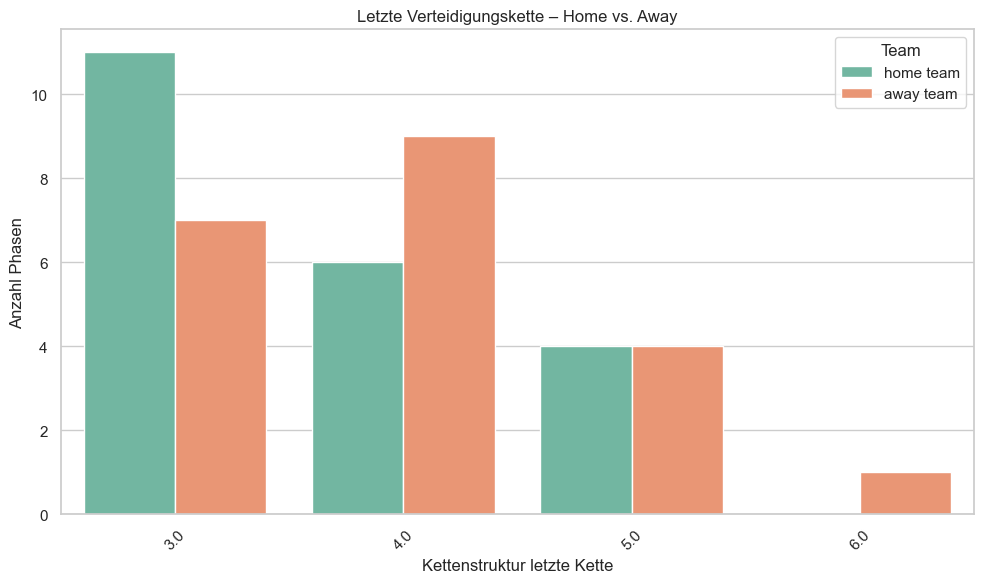

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")

home_ketten = ballbesitz_summary_geordnet[ballbesitz_summary_geordnet['defending_team'] == 'away team']['verteidigungskette']
away_ketten = ballbesitz_summary_geordnet[ballbesitz_summary_geordnet['defending_team'] == 'home team']['verteidigungskette']

combined_df = ballbesitz_summary_geordnet[['defending_team', 'verteidigungskette']].copy()

plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='verteidigungskette', hue='defending_team', palette='Set2')

plt.title('Letzte Verteidigungskette – Home vs. Away')
plt.xlabel('Kettenstruktur letzte Kette')
plt.ylabel('Anzahl Phasen')
plt.legend(title='Team')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


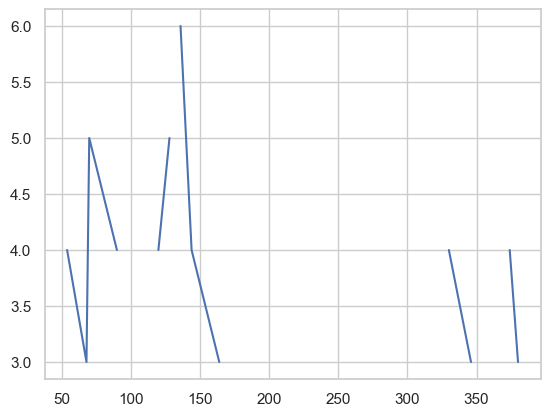

In [147]:
plt.plot(ballbesitz_summary_geordnet[ballbesitz_summary_geordnet['defending_team']=='away team']['verteidigungskette'], label='Verteidigungskette')